# *In silico* predictions at subcellular resolution

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 
device = 'cuda:1'

In [3]:
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()
cell_names = np.loadtxt(f'{data_path}{dataset}/cell_names.txt', dtype=str)

test_seqfish = np.load(f"{data_path}{dataset}/test_seqfish.npz")  # 或 "cuda"
test_image = test_seqfish["data_ori"]
test_cell_morphology = test_seqfish["cell_morphology"]
test_nuclear_morphology = test_seqfish["nuclear_morphology"]
test_data_location = test_seqfish["location"]
test_cell_cycle_label = test_seqfish["identity_label"]
test_cell_cycle = test_seqfish["identity"]
test_cell_names = test_seqfish["cell_names"]

test_dataset = SVC_Dataset(
    data_ori=test_image,
    location=test_data_location,
    cell_morphology_vec=test_cell_morphology,
    nuclear_morphology_vec=test_nuclear_morphology,
    identity_vec=test_cell_cycle_label,
)
print("number of testing cells:", len(test_dataset),', number of genes:', test_image.shape[1])
train_count_sum = np.load(f'{data_path}output/seqfish/train_count_sum.npy')
read_dir =f'{data_path}{dataset}/gene2vec_weight_seqfish.npy'
gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() 
val_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 4)

number of testing cells: 14 , number of genes: 1000


**20-fold cross-prediction for validation**

In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True, random_state=2025)

groups = []
for train_index, test_index in kf.split(gene_names):
    groups.append(np.array(gene_names)[test_index])

for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['Abcf2' 'Actn1' 'Aldh9a1' 'Angptl2' 'Atp10a' 'Camsap2' 'Cherp' 'Csnk2a1'
 'Ctnna1' 'Ddb1' 'Ehmt2' 'Eif2b5' 'Eif3d' 'Fbln5' 'Gtpbp1' 'Hipk2' 'Iars2'
 'Ier5' 'Igf2bp2' 'Jdp2' 'Kpna6' 'Ldlr' 'Mlec' 'Myo1c' 'Napa' 'Ndel1'
 'Nfkbia' 'Noc2l' 'Nsdhl' 'Nucks1' 'Pgd' 'Pgm1' 'Picalm' 'Pomgnt1'
 'Ppp6r3' 'Rbpj' 'Rps6ka4' 'Smarca4' 'Socs5' 'Spry2' 'Ssrp1' 'Stk11'
 'Stt3b' 'Sympk' 'Tcf20' 'Trp53' 'Tspan9' 'Uap1' 'Wwtr1' 'Zcchc14']
Group 2: ['Aff4' 'Anln' 'Arhgef17' 'Asns' 'Bak1' 'Bicc1' 'Bms1' 'Ccng1' 'Clstn1'
 'Creb3l2' 'Cse1l' 'Cul1' 'Cyfip1' 'Cyp51' 'Dctn1' 'Elovl1' 'Fam32a'
 'Fmr1' 'Gbf1' 'Hadh' 'Larp4' 'Lox' 'Lta4h' 'Mcm3' 'Mybbp1a' 'Myh10'
 'Nasp' 'Ncapd2' 'Nfic' 'Nr2f2' 'Pdgfrb' 'Pigt' 'Polr2a' 'Rhoj' 'Rnh1'
 'Ruvbl1' 'Sdc2' 'Sf3b3' 'Slit2' 'Smarcc2' 'Smc3' 'Steap2' 'Steap3'
 'Tanc2' 'Tcf3' 'Tead1' 'Tomm40' 'Twf1' 'Uba1' 'Ube2g2']
Group 3: ['Aacs' 'Aldh1l2' 'Ankrd17' 'Cav1' 'Chaf1a' 'Champ1' 'Chpf' 'Col3a1'
 'Col5a2' 'Ddx6' 'Ddx18' 'Dock7' 'Fam168b' 'Ftsj3' 'Galk1' 'Gas7' 'Gng12'
 

In [5]:
ckpt_dir = f"{data_path}/checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_seqfish.pth', map_location=device)

state = ckpt.get("model_state_dict", ckpt)  
state = {k.removeprefix("module."): v for k, v in state.items()}

model = SVC(
    gene2vec_weight = gene2vec_weight,
    cell_identity_dim = test_cell_cycle_label.shape[1],
).to(device)

model.load_state_dict(state)


<All keys matched successfully>

**save the mean and dispersion paramater for each pixel, and set the background pixel values to 0**

In [6]:


prediction_impute_mu = torch.zeros(test_image.shape).to(device) 
prediction_impute_r = torch.zeros(test_image.shape).to(device)

background_pixel = torch.Tensor([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]]).to(device).to(torch.long)

model.eval()

for selected_gene in groups:

    gene_to_impute = [gene_names.index(i) for i in selected_gene if i in gene_names]
    gene_not_to_impute = [gene for gene in range(len(gene_names)) if gene not in gene_to_impute]

    predictions_mu= []     
    predictions_r = []

    with torch.no_grad():
        for i, (inputs_ori, cell_morphology, nuclear_morphology, location, cell_cycle) in enumerate(val_loader, 0):

            inputs_ori = inputs_ori.to(device).float()  
            location = location.to(device).float()
            cell_morphology = cell_morphology.to(device).float()
            nuclear_morphology = nuclear_morphology.to(device).float()
            cell_cycle = cell_cycle.to(device).float()
            
            inputs_ori_mask = inputs_ori.clone()
            inputs_ori_mask[:,gene_to_impute] = 0

            cell_median_train = np.median((train_count_sum[:,gene_not_to_impute]).sum(axis=1))
            size_factor = (inputs_ori_mask.sum((1,2,3))/cell_median_train).unsqueeze(1).unsqueeze(2).unsqueeze(3)
            inputs = inputs_ori / size_factor  # (n_cell, n_gene, 12, 12)


            mask = torch.zeros(inputs.shape[0], inputs.shape[1]).to(device).bool()
            
            mask[:,gene_to_impute] = True
            inputs_mask = inputs.clone()
            inputs_mask[:,gene_to_impute] = 0
            _, predicts_mu, predicts_r= model(inputs_mask, mask, location, cell_morphology, nuclear_morphology, cell_cycle)             
            predicts_mu = predicts_mu * size_factor  # batch*gene*h*w


            predictions_mu.append(predicts_mu)
            predictions_r.append(predicts_r)
        

            
    predictions_mu = torch.cat(predictions_mu, dim=0)
    predictions_r = torch.cat(predictions_r, dim=0)

    predictions_mu[:,:,background_pixel[:,0],background_pixel[:,1]] = 0
    predictions_r[:,:,background_pixel[:,0],background_pixel[:,1]] = 0

    prediction_impute_mu[:,gene_to_impute] = predictions_mu[:,gene_to_impute]     
    prediction_impute_r[:,gene_to_impute] = predictions_r[:,gene_to_impute]
# np.savez_compressed(f'{data_path}output/seqfish/prediction_all_genes_mu.npz', prediction=prediction_impute_mu.cpu().numpy())
# np.savez_compressed(f'{data_path}output/seqfish/prediction_all_genes_r.npz', prediction=prediction_impute_r.cpu().numpy())

**first compare the predicted cellular expression values vs ground truth at single-cell level**

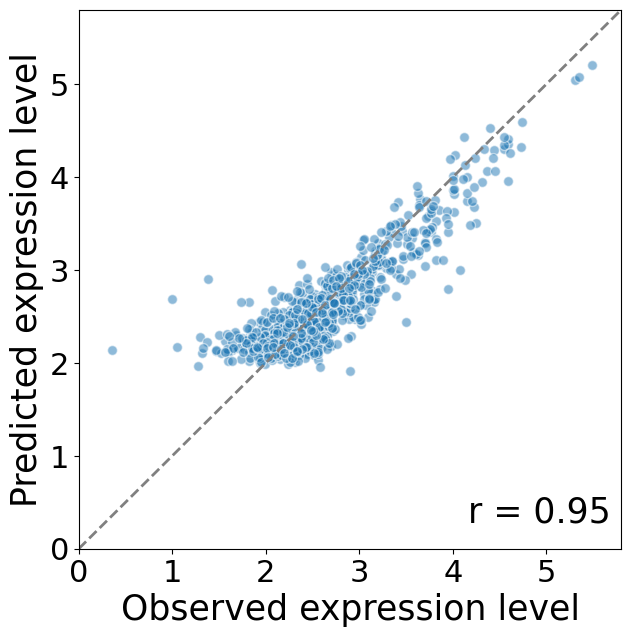

In [7]:
pred_exp_level_SVC = (prediction_impute_mu.cpu().numpy().sum((-1,-2))).mean(0)
exp_level = (test_image.sum((-1,-2))).mean(0)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(np.log1p(exp_level), np.log1p(pred_exp_level_SVC), s=50, alpha=0.5,edgecolors='white')
plt.plot([0, 6], [0, 6], '--', lw=2, color='gray')
plt.xlim(0, 5.8)
plt.ylim(0, 5.8)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([0,1,2,3,4,5],fontsize=22)
ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels([0,1,2,3,4,5],fontsize=22)
plt.xlabel('Observed expression level',fontsize=25)
plt.ylabel('Predicted expression level',fontsize=25)
ax.text(0.98, 0.05, f'r = {np.corrcoef(exp_level, pred_exp_level_SVC)[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
plt.show()


**focus on the 49 well-annotated genes** 

In [8]:
# seqfish+ genes in extended data fig 3
protrusionList = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclearList = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasmList = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

In [9]:
selected_gene = protrusionList + nuclearList + cytoplasmList
selected_gene_idx = [gene_names.index(i) for i in selected_gene]
print("gene to impute:",selected_gene_idx)

gene to impute: [203, 775, 219, 421, 417, 250, 63, 249, 586, 522, 168, 319, 299, 174, 92, 546, 443, 582, 24, 279, 171, 753, 635, 169, 601, 172, 411, 108, 599, 217, 516, 14, 865, 427, 374, 639, 376, 590, 864, 323, 662, 107, 817, 934, 377, 111, 842, 945, 113]


**calculate pred and observed relative distance to nuclear center for each gene**

In [10]:
prediction_gene_ratio = np.zeros((len(test_dataset),len(selected_gene_idx)))
truth_gene_ratio = np.zeros((len(test_dataset),len(selected_gene_idx)))

I = 0
for cell in range(len(test_dataset)):
    cell_gene_pred = prediction_impute_mu[cell].cpu().numpy()
    cell_gene_real = test_image[cell]
    J = 0
    for gene in selected_gene_idx:
        heatmap_pred = cell_gene_pred[gene,:,:,]  
        heatmap_real = cell_gene_real[gene,:,:,]

        prediction_gene_ratio[I,J] = compute_relative_dist_to_nuclear_center(heatmap_pred)
        truth_gene_ratio[I,J] = compute_relative_dist_to_nuclear_center(heatmap_real)
        J += 1
    I += 1

In [11]:
gene_to_impute_type = []
for i in selected_gene:
    if i in protrusionList:
        gene_to_impute_type.append('Protrusion')
    elif i in cytoplasmList:
        gene_to_impute_type.append('Cytoplasm')
    else:
        gene_to_impute_type.append('Nuclear/Perinuclear')
gene_to_impute_type_dict = {'Protrusion':1,'Cytoplasm':2,'Nuclear/Perinuclear':3}
gene_to_impute_type_num = np.array([gene_to_impute_type_dict[i] for i in gene_to_impute_type])

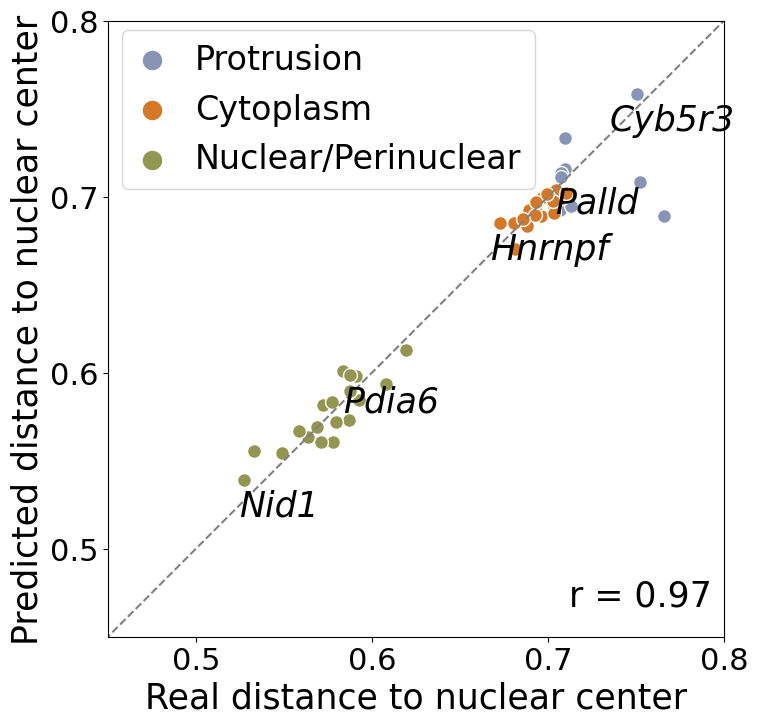

In [12]:
prediction_gene_ratio_mean = np.nanmean(prediction_gene_ratio,axis=0)
prediction_gene_ratio_mean = np.array(prediction_gene_ratio_mean).reshape(-1,1)
truth_gene_ratio_mean =  np.nanmean(truth_gene_ratio,axis=0)
truth_gene_ratio_mean = np.array(truth_gene_ratio_mean).reshape(-1,1)
impute_real_concat = np.concatenate((truth_gene_ratio_mean,prediction_gene_ratio_mean), axis=1)

representative_genes = ['Nid1', 'Pdia6', "Hnrnpf", "Palld", "Cyb5r3"]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = prediction_gene_ratio_mean
custom_colors = ["#8794b6","#d47828","#939650"] 
i=0
for type in gene_to_impute_type_dict:
    ax.scatter(impute_real_concat[np.array(gene_to_impute_type) == type,0], impute_real_concat[np.array(gene_to_impute_type) == type,1],c=custom_colors[i],s=100,label=type,edgecolor='white')
    i+=1
ax.legend(title='',fontsize=24,bbox_to_anchor=(0.72, 0.7),markerscale=1.5,handlelength=1)
ax.text(0.98, 0.05, f'r = {np.corrcoef(impute_real_concat[:,0], impute_real_concat[:,1])[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
for gene in selected_gene:
    if gene in representative_genes:
        ax.annotate(gene, (impute_real_concat[selected_gene.index(gene),0]+0.02, impute_real_concat[selected_gene.index(gene),1]-0.001), textcoords="offset points", xytext=(0,-25), ha='center', fontsize=25,fontstyle="italic")
ax.set_aspect('equal')
ax.plot([0, 0.8], [0, 0.8], '--', color='gray')
ax.set_xlim(0.45, 0.8)
ax.set_ylim(0.45, 0.8)
ax.set_xticks([0.5,0.6,0.7,0.8])
ax.set_xticklabels([0.5,0.6,0.7,0.8],fontsize=22)
ax.set_yticks([0.5,0.6,0.7,0.8])
ax.set_yticklabels([0.5,0.6,0.7,0.8],fontsize=22)
ax.set_xlabel('Real distance to nuclear center', fontsize=25)
ax.set_ylabel('Predicted distance to nuclear center', fontsize=25)
plt.show()

**pred and observed subcellular pattern for representative genes**

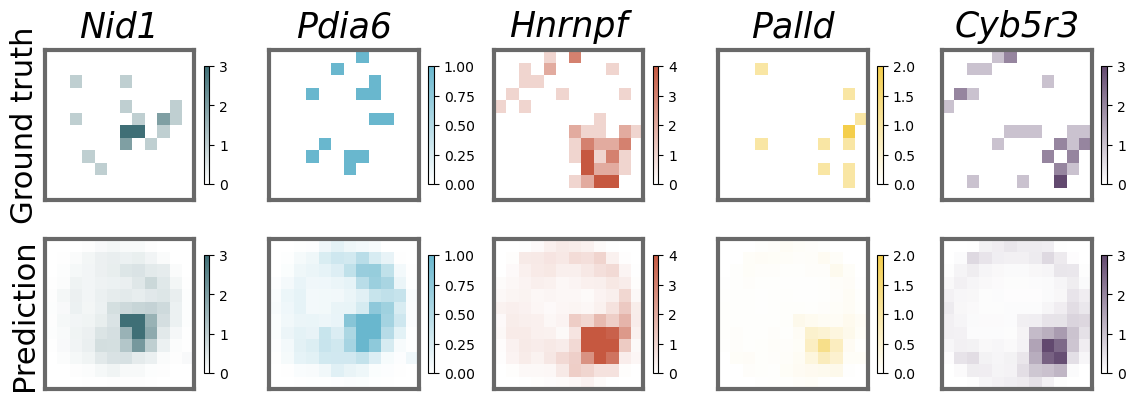

In [13]:
colors = ['#3f6f76', '#69b7ce', '#c65840', '#f4ce4b', '#62496f']
custom_cmap  = [create_white_to_color_cmap(i) for i in colors]
gene_set = ["Nid1", "Pdia6", "Hnrnpf", "Palld", "Cyb5r3"]
cell = '16-3'
cell_idx = list(test_cell_names).index(cell)

fig, ax = plt.subplots(2, 5, figsize=(14, 4.5), gridspec_kw={ "hspace": 0.2})
i = 0


for gene in gene_set:

    cell_gene = prediction_impute_mu[cell_idx].cpu().numpy()
    cell_gene_real = test_image[cell_idx]
    vmax = cell_gene_real[gene_names.index(gene),:,:,].max()
    cell_gene_sum = cell_gene.sum(axis = 0)

    ax0 = ax[0,i].imshow(cell_gene_real[gene_names.index(gene),:,:,], cmap=custom_cmap[i],vmin=0,vmax=vmax)#,vmin=-0.2,vmax=15)
    if  i == 0:
        ax[i,0].set_ylabel("Ground truth",fontsize=22)
    ax[0,i].set_title(f"{gene_names[gene_names.index(gene)]}",fontsize=25,pad=10,fontstyle='italic')
    cbar = plt.colorbar(ax0,shrink=0.75)
    
    ax[0,i].invert_yaxis()
    for spine in ax[0,i].spines.values():
        spine.set_linewidth(3)
        spine.set_color('dimgrey')
    ax1 = ax[1,i].imshow(cell_gene[gene_names.index(gene),:,:,], cmap=custom_cmap[i],vmin=0,vmax=vmax)
    cbar = plt.colorbar(ax1,shrink=0.75)
    if  i == 0:
        ax[1,i].set_ylabel(f"Prediction",fontsize=22)
    ax[1,i].invert_yaxis()
    for spine in ax[1,i].spines.values():
        spine.set_linewidth(3)
        spine.set_color('dimgrey')
    ax[0,i].set_xticks([])  # 隐藏 x 轴刻度
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    i+=1
 
plt.tight_layout()
plt.show()
plt.close()


**postprocessing: map the predicted high-resolution spatial expression from the unified cellular coordinate system back to the original cell morphology**

- NB sampling

- calculating the relative radial distance and the angular position for each pixel

- identifying the cellular boundary point corresponding to the same angle

- determining the Cartesian coordinates of the transcript within the original cell


In [14]:
prediction_49_genes_mu = prediction_impute_mu[:,selected_gene_idx].cpu().numpy()
prediction_49_genes_r = prediction_impute_r[:,selected_gene_idx].cpu().numpy()
# np.savez_compressed(f'{data_path}output/seqfish/prediction_49_genes_mu.npz', prediction=prediction_49_genes_mu)
# np.savez_compressed(f'{data_path}output/seqfish/prediction_49_genes_r.npz', prediction=prediction_49_genes_r))
count_data = postprocess_sampling(prediction_49_genes_mu, prediction_49_genes_r, seed=2025)
print("shape of count_data:",count_data.shape)

100%|██████████| 14/14 [00:00<00:00, 127.37it/s]

shape of count_data: (14, 49, 48, 48)


In [15]:
predictions_pixel = postprocess_predictions(count_data, selected_gene, test_cell_names)

In [16]:
df_cell_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(df_cell_contour.head())
df_nuclear_contour = pd.read_pickle(f"{data_path}{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(df_nuclear_contour.head())

  cell    x    y  centerX  centerY  direction_vec  distance_to_center
0  0-0  521  496     1079      724         -158.0          602.783543
1  0-0  519  496     1079      724         -158.0          604.635427
2  0-0  517  494     1079      724         -157.5          607.242950
3  0-0  515  494     1079      724         -158.0          609.094410
4  0-0  513  492     1079      724         -157.5          611.702542
  cell     x    y  centerX  centerY
0  0-0  1051  631     1079      724
1  0-0  1050  632     1079      724
2  0-0  1049  632     1079      724
3  0-0  1048  632     1079      724
4  0-0  1047  632     1079      724


In [17]:
predictions_pixel = postprocess_predictions_original(predictions_pixel, df_cell_contour)
print(predictions_pixel.head())
# predictions_pixel.to_csv(f"{data_path}output/seqfish/prediction_count_data_49_genes.csv")
    

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


  cell    gene  count   x  y     ratio  direction_vec  centerX  centerY  \
0  1-3  Cyb5r3    1.0  25  0  0.981159          -86.5     1026     1173   
1  1-3  Cyb5r3    1.0  27  1  0.948775          -81.0     1026     1173   
2  1-3  Cyb5r3    1.0  34  1  1.000000          -65.0     1026     1173   
3  1-3  Cyb5r3    1.0  35  4  0.943269          -59.5     1026     1173   
4  1-3  Cyb5r3    1.0  22  5  0.773363          -94.5     1026     1173   

   distance_to_center  angle_radians   x_original   y_original  
0          161.208985      -1.509710  1035.841573  1012.091702  
1          163.464839      -1.413717  1051.571535  1011.547685  
2          287.200279      -1.134464  1147.376082   912.708151  
3          230.041701      -1.038471  1142.754988   974.789363  
4          127.292819      -1.649336  1016.012721  1046.099582  


**visualization at original scale**

In [18]:
data = pd.read_pickle(f"{data_path}{dataset}/seqfish_data_dict.pkl")
seqfish_data = data['data_df']
print(seqfish_data.head())

             x           y           gene cell nucleus batch  umi  centerX  \
0  1217.437557  557.583252  4933401b06rik  5-0      -1     0    1     1003   
1  1096.190309  394.835294  4933401b06rik  5-0       5     0    1     1003   
2  1093.189494  572.832405  4933401b06rik  5-0      -1     0    1     1003   
3  1005.120220  297.196271  4933401b06rik  5-0      -1     0    1     1003   
4  1142.815026  378.376491  4933401b06rik  5-0      -1     0    1     1003   

   centerY        type  sc_total  
0      425  fibroblast     32224  
1      425  fibroblast     32224  
2      425  fibroblast     32224  
3      425  fibroblast     32224  
4      425  fibroblast     32224  


In [19]:
preserve_idx_cell_mask_contour =[]
for i in df_cell_contour.cell:
    if i in test_cell_names:
        preserve_idx_cell_mask_contour.append(True)
    else:
        preserve_idx_cell_mask_contour.append(False)

preserve_idx_nuclear_mask_contour =[]
for i in df_nuclear_contour.cell:
    if i in test_cell_names:
        preserve_idx_nuclear_mask_contour.append(True)
    else:
        preserve_idx_nuclear_mask_contour.append(False)

preserve_idx_seqfish_data =[]
for i in seqfish_data.cell:
    if i in test_cell_names:
        preserve_idx_seqfish_data.append(True)
    else:
        preserve_idx_seqfish_data.append(False)

In [20]:

def plot_boundary(ax, df_cell_contour_i, df_nuclear_contour_i):
    ax.scatter(df_cell_contour_i.x, df_cell_contour_i.y, color="grey", s=6, zorder=20)
    ax.scatter(df_nuclear_contour_i.x, df_nuclear_contour_i.y, alpha=0.6, s=2, color="darkgrey", zorder=20)
    ax.scatter(df_nuclear_contour_i["centerX"], df_nuclear_contour_i["centerY"],
               marker="+", color="dimgray", s=100, zorder=20)
    ax.set_aspect("equal")
    ax.axis("off")

def plot_gene_points(ax, df, genes, colors, xcol, ycol, label_style="italic", legend=True):
    for g, c in zip(genes, colors):
        sub = df[df["gene"] == g]
        ax.scatter(sub[xcol], sub[ycol], s=10, color=c, label=g)
    leg = None
    if legend:
        leg = ax.legend(fontsize=25, markerscale=3, frameon=False)
        if label_style == "italic" and leg is not None:
            for t in leg.get_texts():
                t.set_fontstyle("italic")
    return leg

def plot_truth_pred_pair(ax_truth, ax_pred,
                         truth_df, pred_df_exploded,
                         genes, colors,
                         df_cell_contour_i, df_nuclear_contour_i,
                         title_truth=None, title_pred=None,
                         legend_anchor_truth=None, legend_anchor_pred=None):
    # truth
    plot_boundary(ax_truth, df_cell_contour_i, df_nuclear_contour_i)
    plot_gene_points(ax_truth, truth_df, genes, colors, xcol="x", ycol="y")
    if title_truth:
        ax_truth.set_title(title_truth, fontsize=25, fontweight="bold")
    if legend_anchor_truth is not None:
        ax_truth.legend_.set_bbox_to_anchor(legend_anchor_truth)

    # pred
    plot_boundary(ax_pred, df_cell_contour_i, df_nuclear_contour_i)
    plot_gene_points(ax_pred, pred_df_exploded, genes, colors, xcol="x_original", ycol="y_original", legend=False)
    if title_pred:
        ax_pred.set_title(title_pred, fontsize=25, fontweight="bold")
    if legend_anchor_pred is not None:
        ax_pred.legend_.set_bbox_to_anchor(legend_anchor_pred)



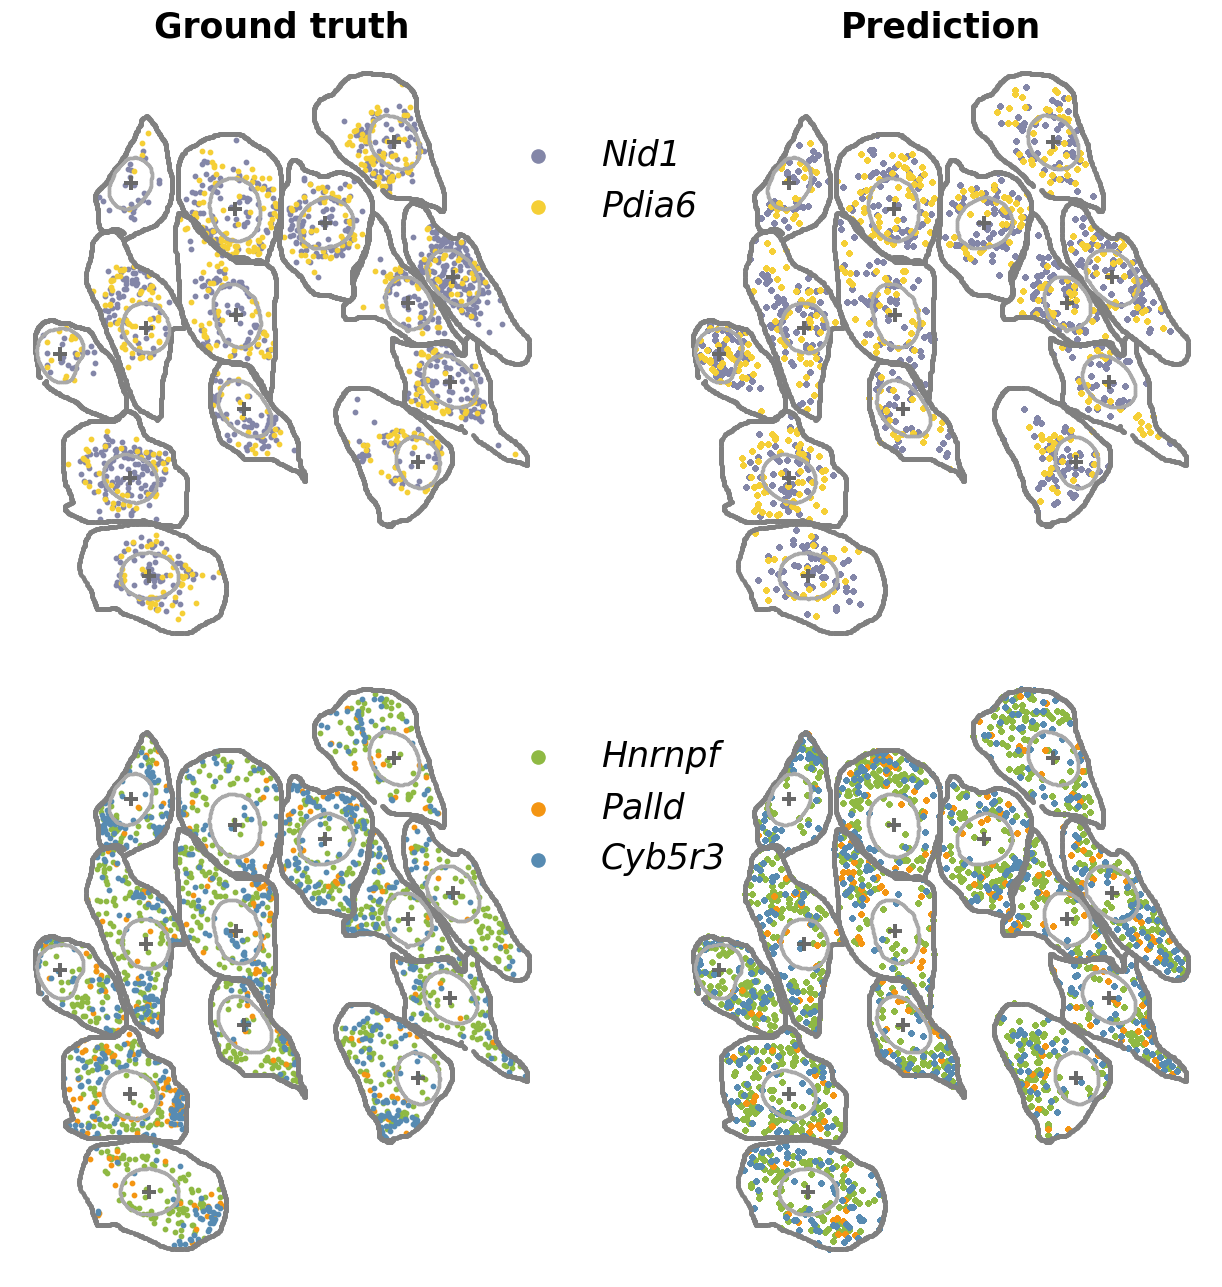

In [21]:
truth_i = seqfish_data[preserve_idx_seqfish_data]
df_cell_contour_i = df_cell_contour[preserve_idx_cell_mask_contour]
df_nuclear_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]
pred_exploded = predictions_pixel.loc[predictions_pixel.index.repeat(predictions_pixel['count'])].reset_index(drop=True)

# ---- plotting ----
fig, ax = plt.subplots(2, 2, figsize=(17, 16), gridspec_kw={"hspace": 0., "wspace": 0.})

genes1 = ["Nid1", "Pdia6"]
plot_truth_pred_pair(
    ax[0, 0], ax[0, 1],
    truth_df=truth_i, pred_df_exploded=pred_exploded,
    genes=genes1, colors=["#8386a8", "#f5cf36"],
    df_cell_contour_i=df_cell_contour_i, df_nuclear_contour_i=df_nuclear_contour_i,
    title_truth="Ground truth", title_pred="Prediction",
    legend_anchor_truth=(0.85, 0.9)
)

genes2 = ["Hnrnpf", "Palld", "Cyb5r3"]
plot_truth_pred_pair(
    ax[1, 0], ax[1, 1],
    truth_df=truth_i, pred_df_exploded=pred_exploded,
    genes=genes2, colors=["#8fb943", "#f49512", "#578bb2"],
    df_cell_contour_i=df_cell_contour_i, df_nuclear_contour_i=df_nuclear_contour_i,
    legend_anchor_truth=(0.85, 0.6)
)

plt.show()
